# Climate Data: CO2 and Snow Accumulation

This lab accompanies a lecture for UC Berkeley's Data 100 by Fernando Pérez and [Dr. Chelle Gentemann](https://cgentemann.github.io) that covers the fundamental physical mechanisms behind global warming and analyzes CO2 and ocean temperature data.

In [1]:
%matplotlib inline

import warnings
from zipfile import ZipFile

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from IPython.display import HTML, Javascript, display
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from scipy.interpolate import CubicSpline


warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['axes.linewidth'] = 0.1
plt.rcParams['patch.linewidth'] = 0

display(HTML("<style>.container { width:100% !important; }</style>"))

## [Mauna Loa CO2](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html)
### Load Data

In [2]:
filename = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'
mlo = pd.read_csv(filename, skiprows=59, na_values=-99.99
                  ).reset_index().dropna()
mlo.columns = ['year', 'month', 'date_index', 'fraction_date', 'c02',
               'data_adjusted_season', 'data_fit',
               'data_adjusted_seasonally_fit', 'data_filled',
               'data_adjusted_seasonally_filed', 'station']
mlo.head(2)

year  month  date_index  fraction_date     c02  data_adjusted_season  \
2  1958      3       21259      1958.2027  315.71                314.44   
3  1958      4       21290      1958.2877  317.45                315.16   

   data_fit  data_adjusted_seasonally_fit  data_filled  \
2    316.19                        314.90       315.71   
3    317.30                        314.98       317.45   

   data_adjusted_seasonally_filed station  
2                          314.44     MLO  
3                          315.16     MLO

### Exploratory Data Analysis
#### Variability in Annual Cycle

Plants take up CO2 in the spring/summer then release it in the fall/winter

In [3]:
trace1 = go.Scatter(x=mlo['fraction_date'], y=mlo['c02'])
trace2 = go.Scatter(x=mlo['fraction_date'],
                    y=mlo['data_adjusted_seasonally_fit'])

fig = make_subplots()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig['layout'].update(height=600, width=700, showlegend=False,
                     title='Atmospheric CO2 at Mauna Loa Observatory',
                     xaxis_title='Year',
                     yaxis_title='CO2 fraction in dry air (ppm)')
iplot(fig)

# plt.plot(data=mlo, 'fraction_date', 'c02')
# plt.plot(data=mlo, 'fraction_date', 'data_adjusted_seasonally_fit')
# plt.title('Atmospheric CO2 at Mauna Loa Observatory')
# plt.xlabel('Year')
# plt.ylabel('CO2 fraction in dry air (ppm)')
# plt.show()

#### Monthly Cycle For All Years
CO2 emission follows a similar monthly cycle each year. There is a slight increase around May and a dip around October.

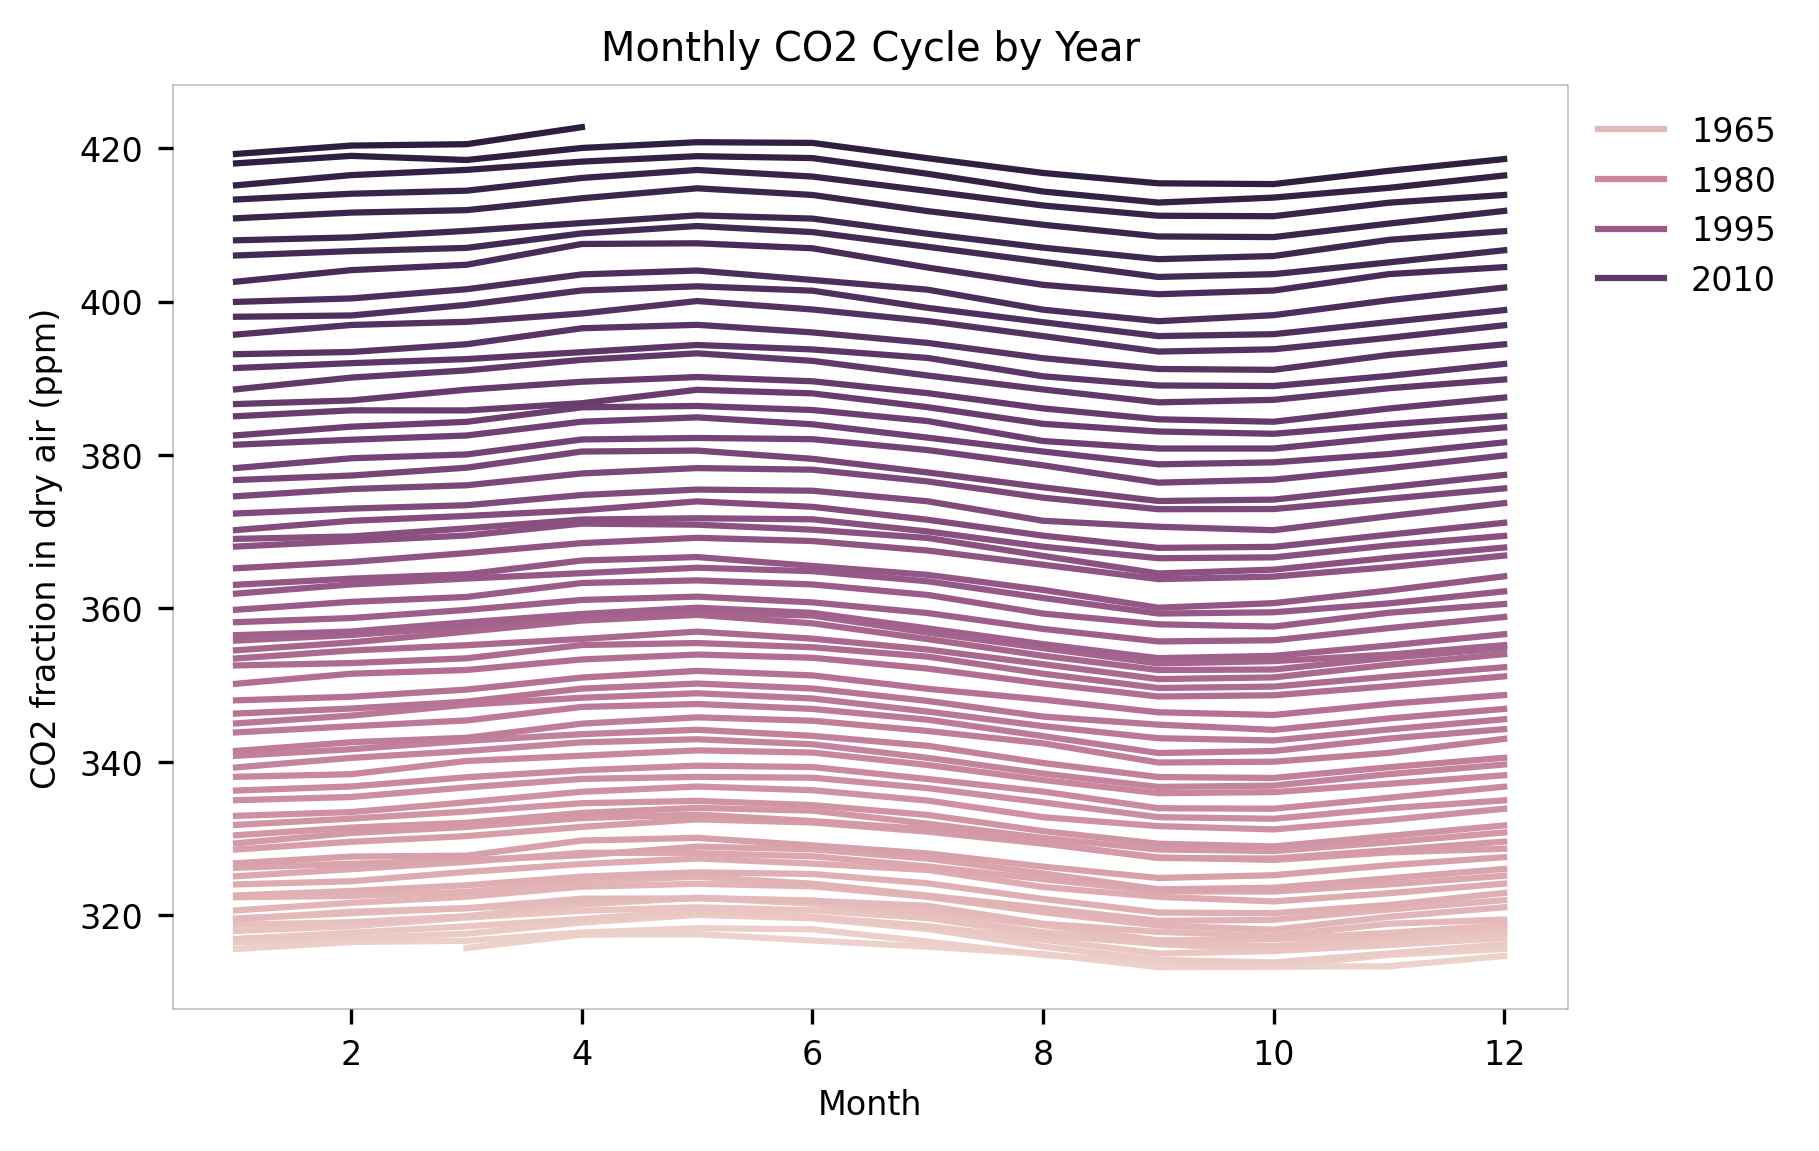

In [4]:
sns.lineplot(data=mlo, x='month', y='c02', hue='year')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Month')
plt.ylabel('CO2 fraction in dry air (ppm)')
plt.title('Monthly CO2 Cycle by Year')
plt.show()

#### Estimate Increase in Amplitude of Annual Cycle

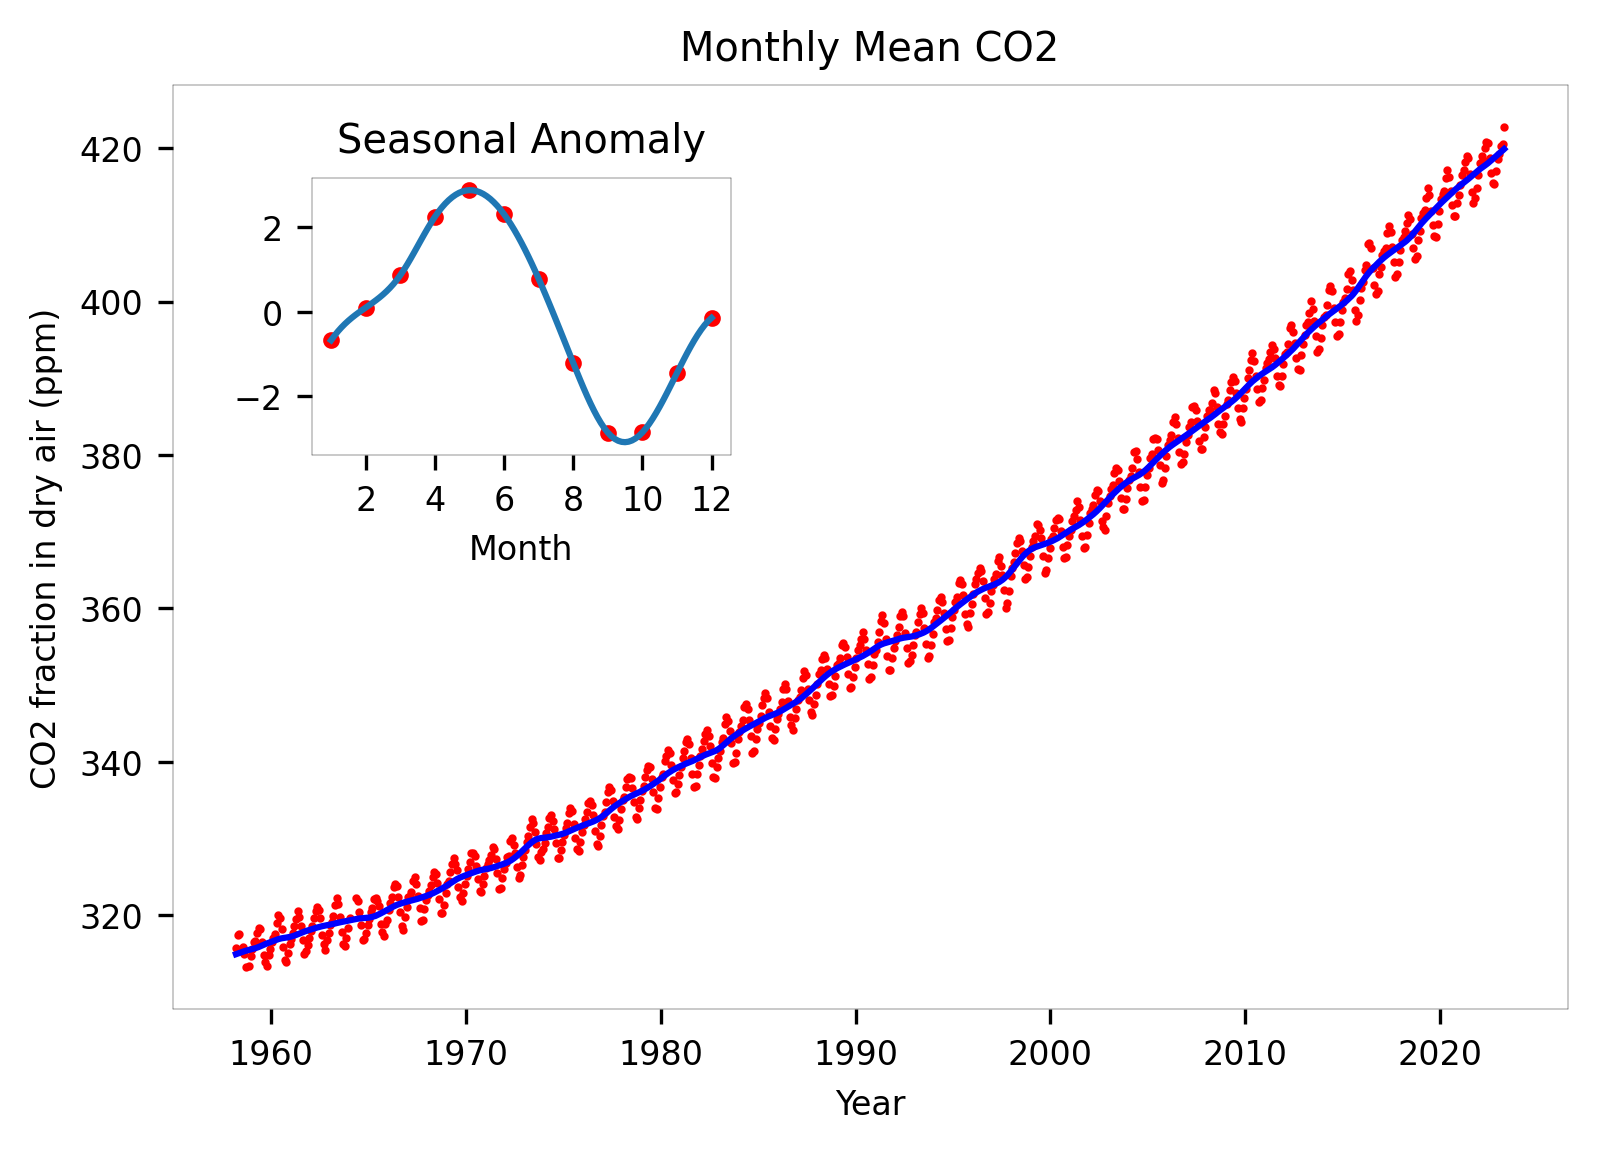

In [5]:
annual = mlo.groupby('month').mean()
anomaly = annual - annual.mean()


def detrend(df):
    temp = df - df.mean()
    temp['month'] = df['month']
    return temp


c02anomaly = mlo.drop(columns='station').groupby('year').apply(detrend)
monthly_anomaly = c02anomaly.groupby('month').mean()[['c02']]
# display(monthly_anomaly)

fig, ax = plt.subplots()
ax.plot(mlo['fraction_date'], mlo['data_filled'], 'r.', markersize=2)
ax.plot(mlo['fraction_date'], mlo['data_adjusted_seasonally_fit'], 'b')
ax.set_xlabel('Year')
ax.set_ylabel('CO2 fraction in dry air (ppm)')
ax.set_title('Monthly Mean CO2')
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.6, 0.3, 0.3])
cs = CubicSpline(monthly_anomaly.index.values, monthly_anomaly.c02)
xs = np.arange(1, 12.1, 0.1)
axin1.plot(monthly_anomaly.index, monthly_anomaly.c02, 'r.')
axin1.plot(xs, cs(xs))
axin1.set_xlabel('Month')
axin1.set_title('Seasonal Anomaly')
axin1.set_xticks(np.arange(2, 13, 2))
plt.show()

## [ERA5: Snow Density](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

### Download and Clean Data

- Product type: Monthly averaged reanalysis
- Variable: Land-sea mask, Snow density
- Year: 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019
- Month: January, February, March, April, May, June, July, August, September, October, November, December
- Time: 00:00

In [6]:
# files = ZipFile('data/era5_snow_monthly.nc.zip')
# ds = xr.open_dataset(files.open(files.namelist()[0]))
# mask = ds.lsm.mean('time') # {0: sea, 1: land, other: assume land}
# snow = ds.rsn.where(mask > 0, drop=True)
# snow = snow.interp(coords={'latitude': snow.latitude[0::7],
#                            'longitude': snow.longitude[0::8]})
# snow.to_netcdf('data/era5_snow.nc')
# # snow

### Load Data

In [7]:
files = ZipFile('data/era5_snow.nc.zip')
snow = xr.open_dataset(files.open(files.namelist()[0])).rsn
snow

<xarray.DataArray 'rsn' (time: 120, latitude: 99, longitude: 180)>
[2138400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
  * latitude   (latitude) float32 83.75 82.0 80.25 78.5 ... -85.0 -86.75 -88.5
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Attributes:
    units:      kg m**-3
    long_name:  Snow density

### Exploratory Data Analysis

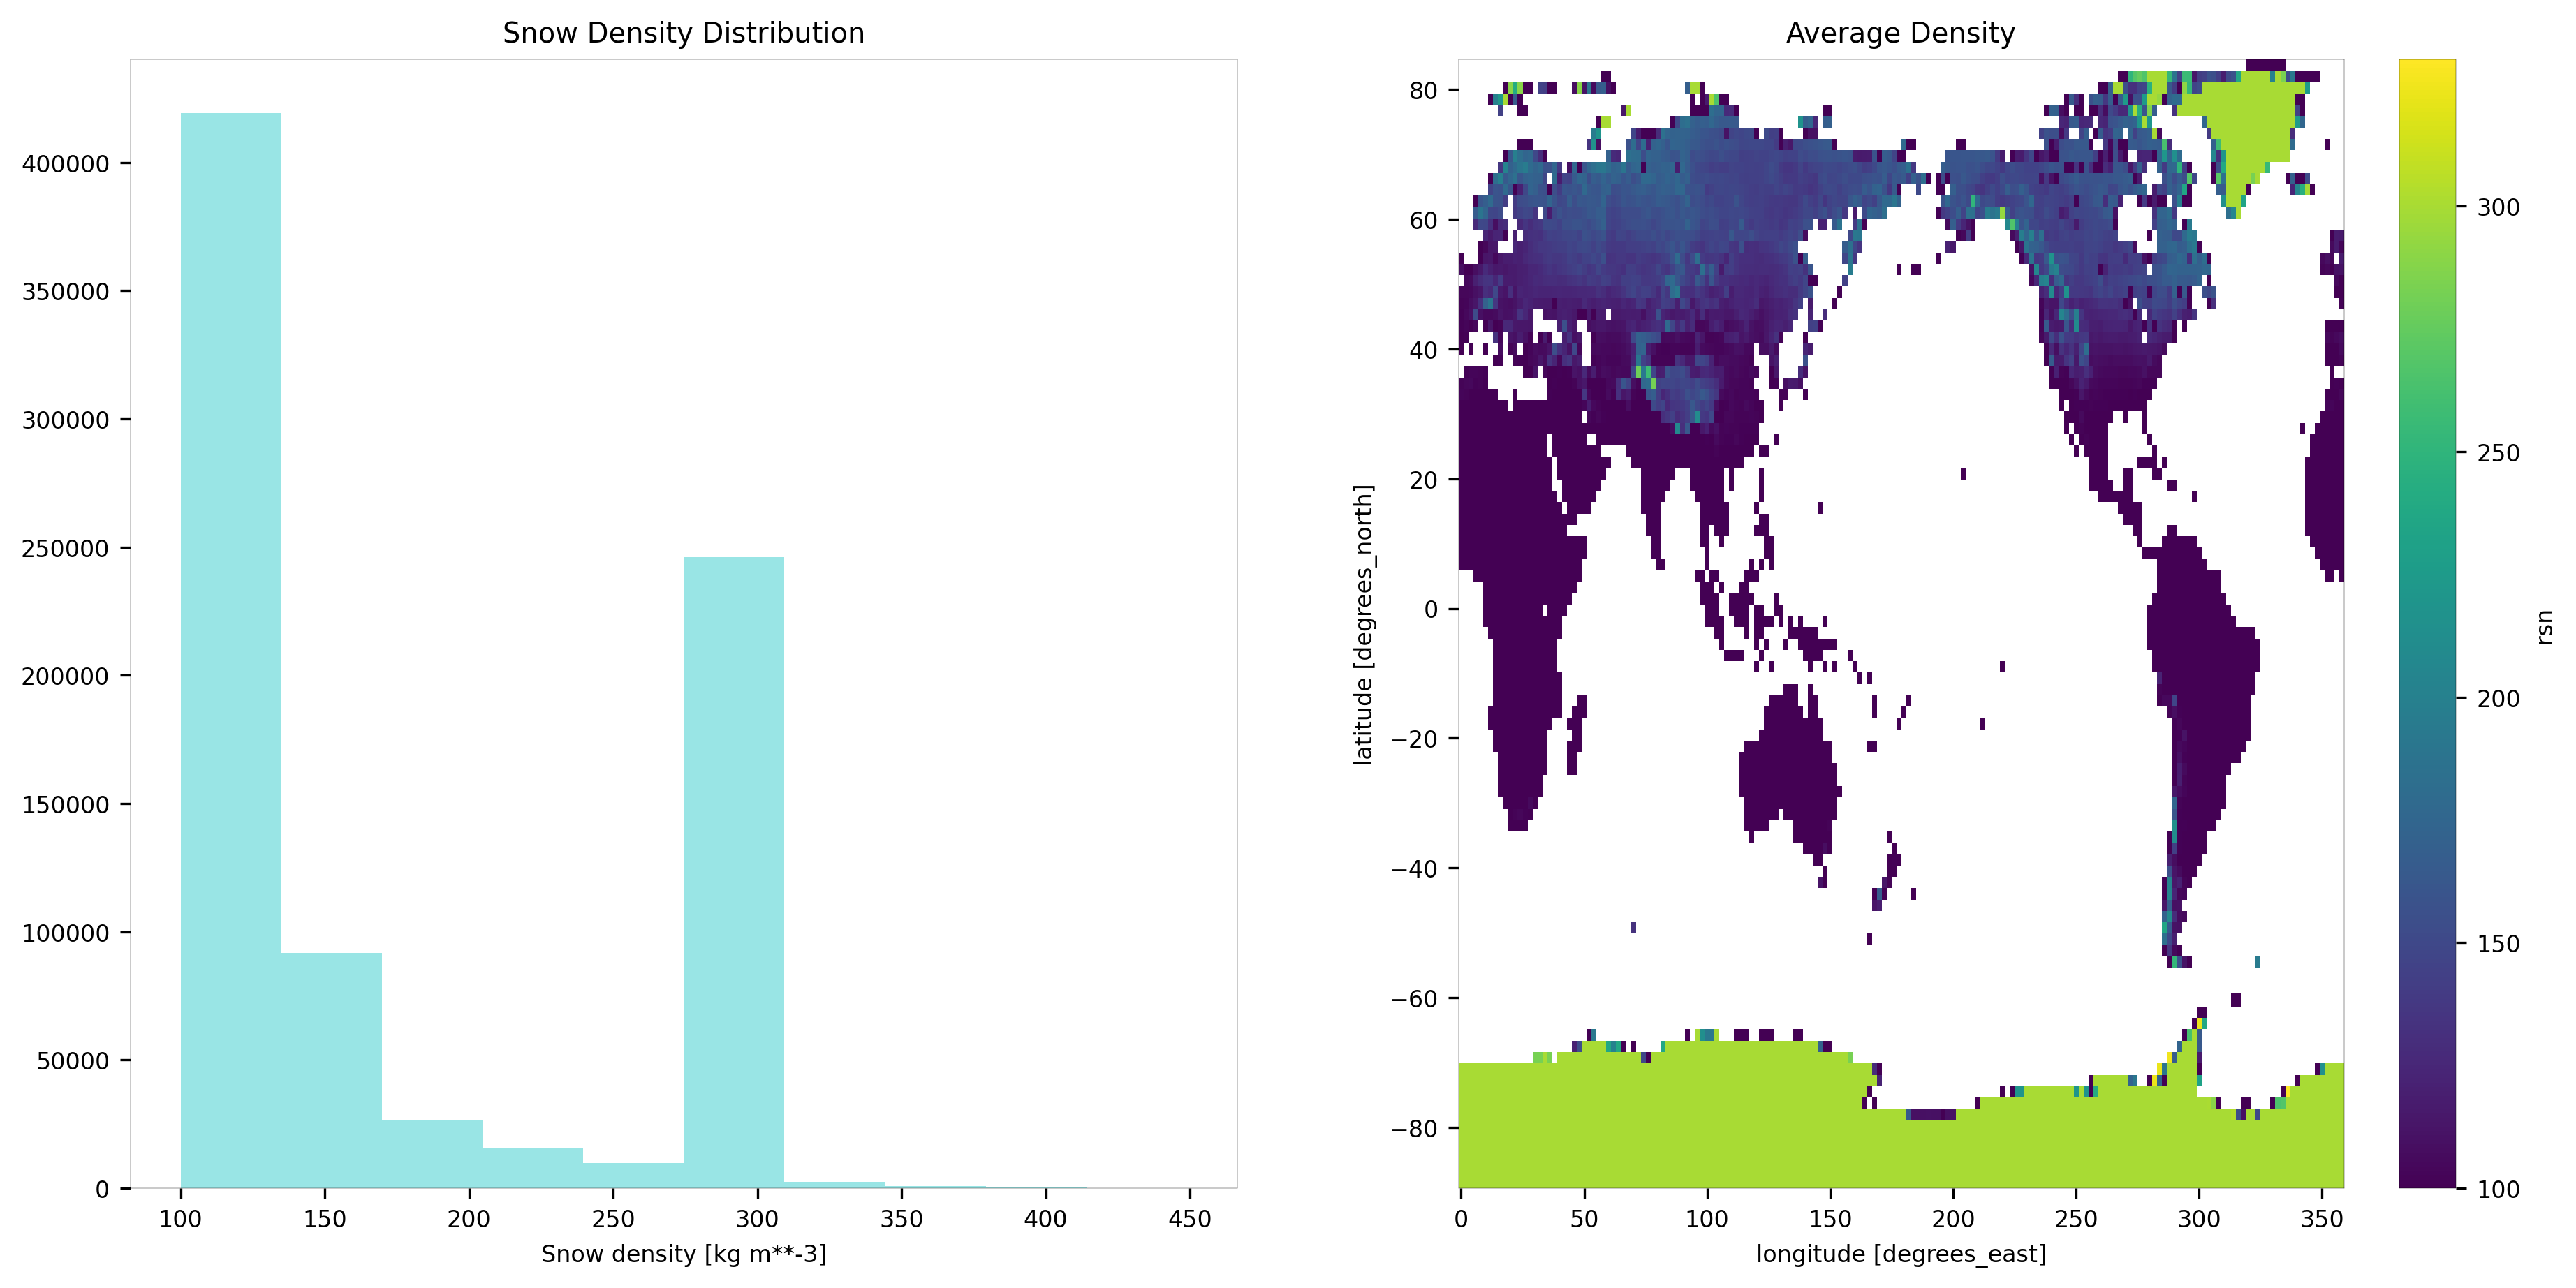

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))

xr.plot.hist(snow, color='c', alpha=0.4, ax=axs[0])
axs[0].set_title('Snow Density Distribution')

snow.mean('time').plot(ax=axs[1])
axs[1].set_title('Average Density')
plt.show()

#### Snow Accumulation Peaks in Summer and Winter of 2000

There is more snow across the globe in February from snowfall in the winter season and less in August from warm weather in the summer. Greenland and Antarctica's snow density was similar both times of the year

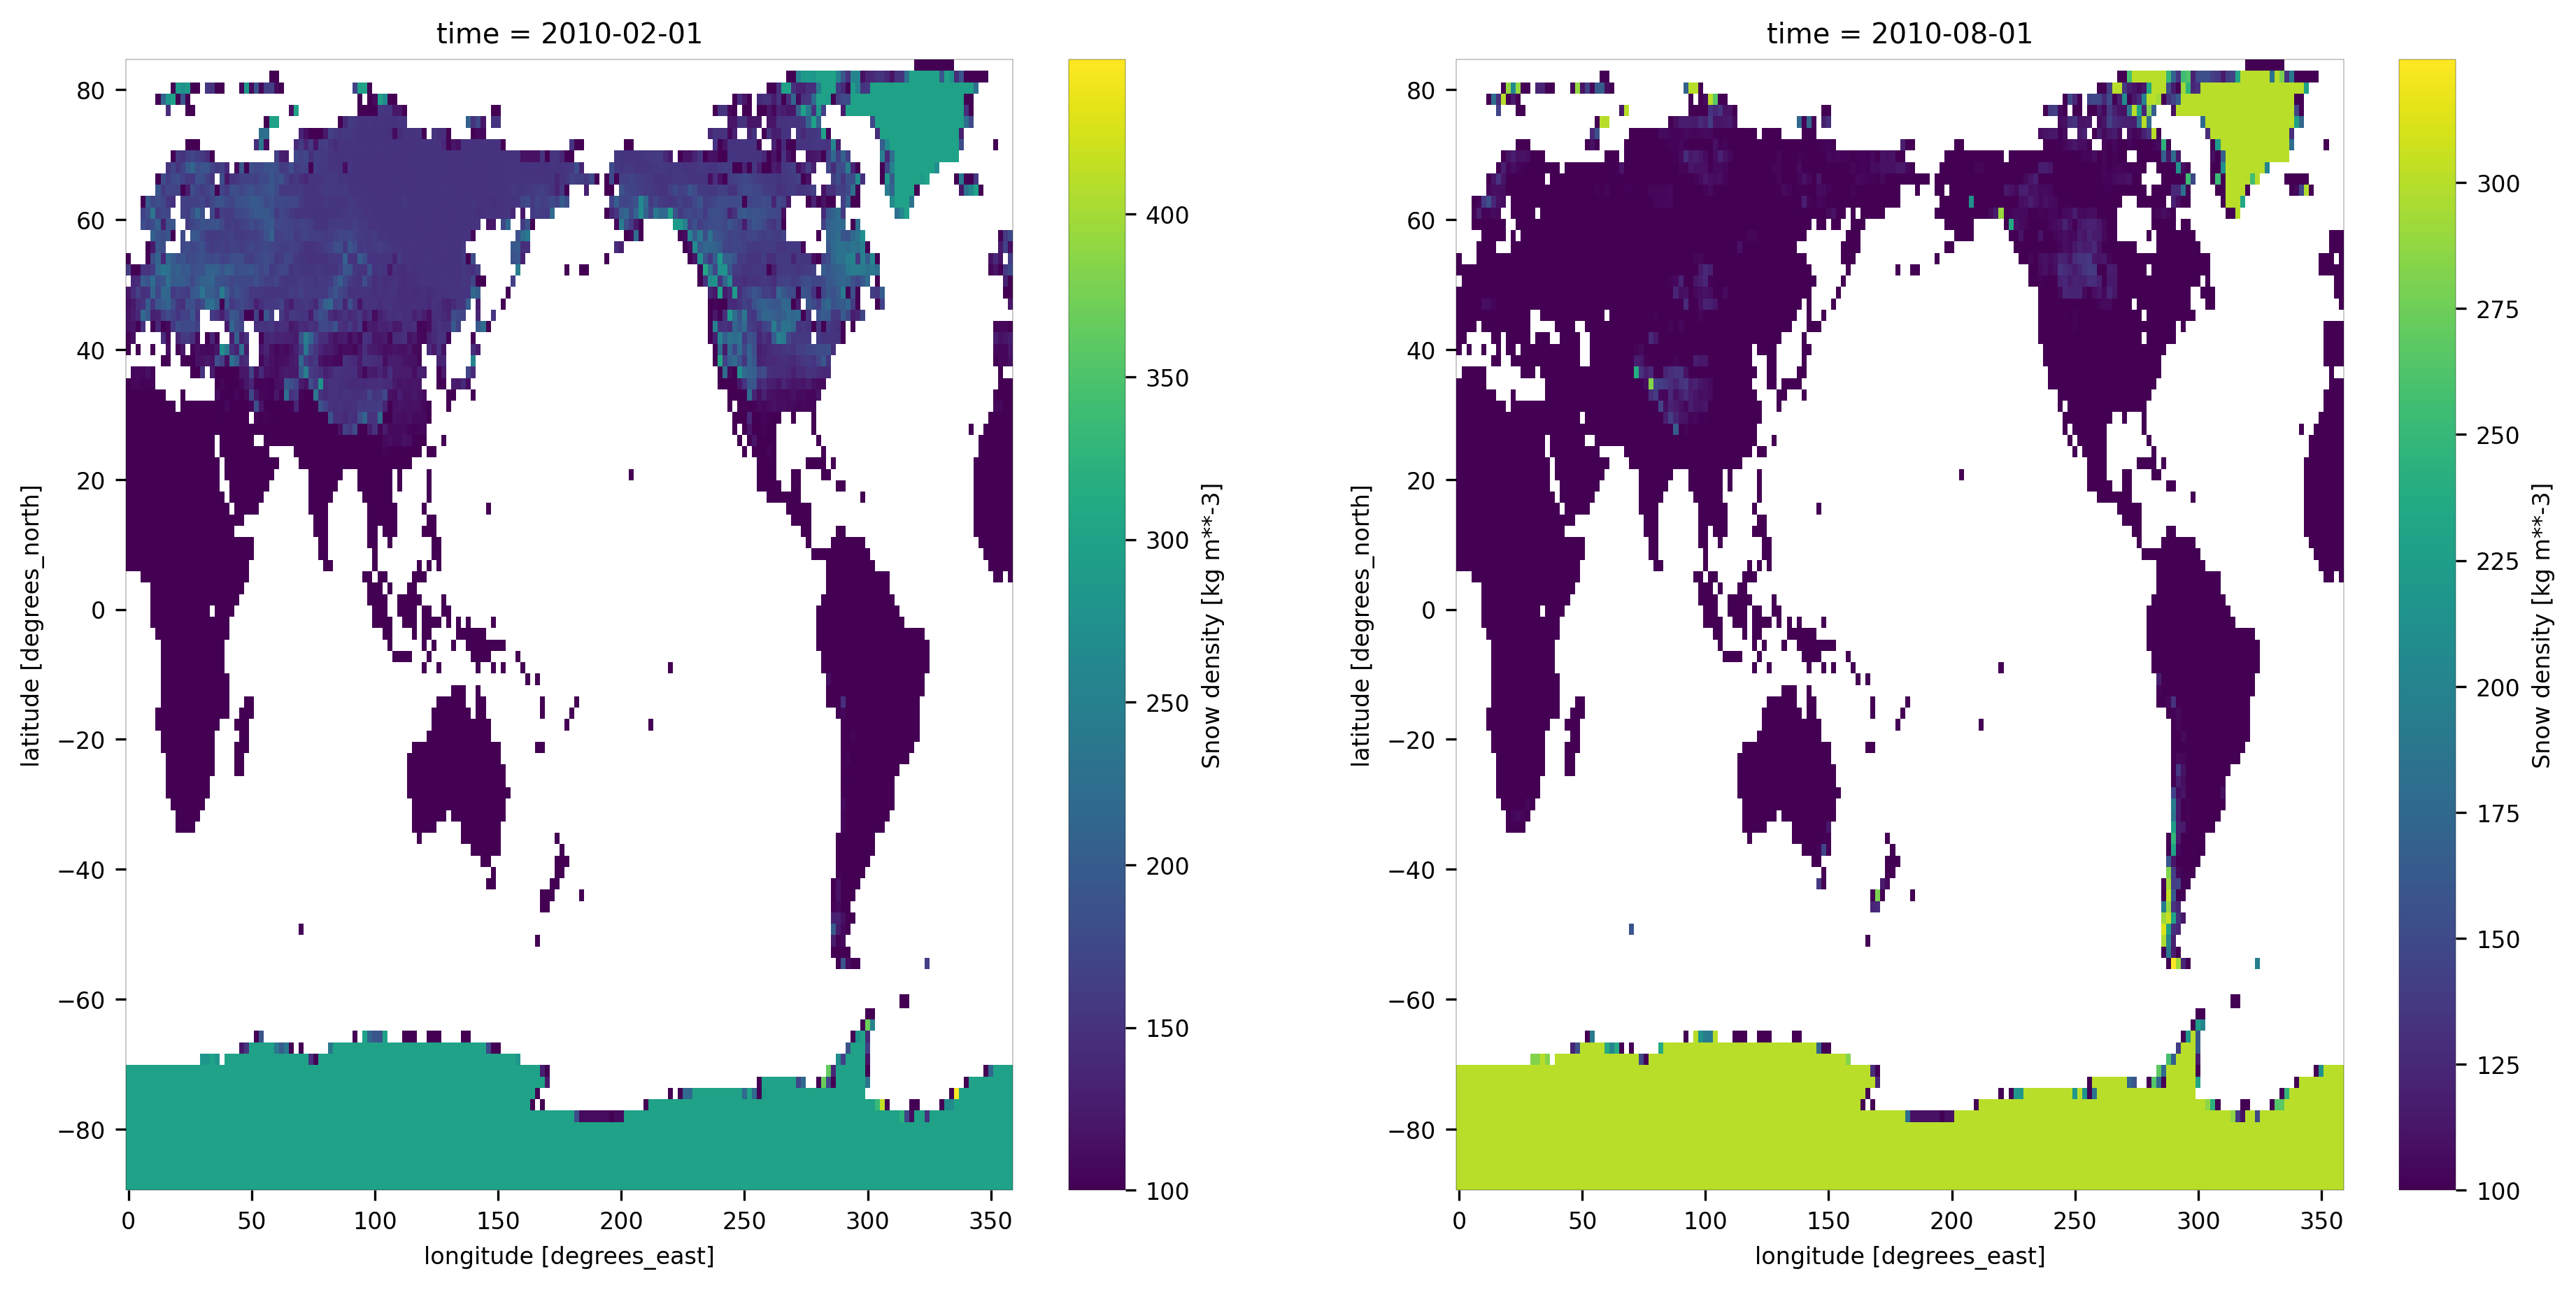

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))

snow.sel(time='2010-02').plot(ax=axs[0])
snow.sel(time='2010-08').plot(ax=axs[1])
plt.show()

## Peaks: Northern vs Southern Hemisphere
On average, snow density peaks at around April and is lowest around July/August in the Northern Hemisphere. Snow density stays relatively constant throughout the year, on average.

In [10]:
by_month = snow.groupby('time.month').mean()
nn = by_month.where(snow.latitude > 0, drop=True).mean(
    ['latitude', 'longitude'])
ss = by_month.where(snow.latitude < 0, drop=True).mean(
    ['latitude', 'longitude'])

trace1 = go.Scatter(x=nn.month, y=nn, name='north')
trace2 = go.Scatter(x=ss.month, y=ss, name='south')

fig = make_subplots()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig['layout'].update(height=600, width=600, showlegend=True,
                     title="Average Monthly Density in the 2010's",
                     xaxis_title='Month', yaxis_title='Snow Density')
iplot(fig)

# nn.plot(label='north')
# ss.plot(label='south')
# plt.legend()
# plt.show()

## Max and Min Snow Density in Northern Hemisphere

Max density in April and fluctuates throughout the years, while min in July/August stays constant

In [11]:
# get peaks for each year


def extract_peaks(da):
    years = np.arange(2010, 2020).astype(str)
    peaks = []

    for y in years:
        snow_sel = da.sel(time=y)
        min_month = pd.to_datetime(snow_sel.idxmin().values).month
        max_month = pd.to_datetime(snow_sel.idxmax().values).month
        int(snow_sel.idxmin().dt.dayofyear)
        int(snow_sel.idxmax().dt.dayofyear)
        min_snow = float(snow_sel.min())
        max_snow = float(snow_sel.max())
        amplitude = max_snow - min_snow
        peaks.append([y, min_month, max_month, min_snow, max_snow, amplitude])

    return pd.DataFrame(peaks, columns=['year', 'min_month', 'max_month',
                                        'min_snow', 'max_snow', 'amplitude'])


peaks = extract_peaks(snow.where(snow.latitude > 0, drop=True)
                      .mean(['latitude', 'longitude']))
display(peaks)

year  min_month  max_month    min_snow    max_snow  amplitude
0  2010          7          4  112.835518  155.768860  42.933342
1  2011          7          4  113.086121  162.643204  49.557083
2  2012          7          4  112.561478  156.796539  44.235062
3  2013          8          4  113.702126  160.700287  46.998161
4  2014          8          4  112.960968  159.668961  46.707993
5  2015          7          4  112.696663  163.593735  50.897072
6  2016          7          4  112.435371  159.232452  46.797081
7  2017          8          4  113.219757  164.261642  51.041885
8  2018          8          4  112.922371  162.334503  49.412132
9  2019          8          4  112.321518  163.467422  51.145905

In [12]:
trace1 = go.Scatter(x=peaks.year, y=peaks.min_snow)
trace2 = go.Scatter(x=peaks.year, y=peaks.max_snow)
# trace3 = go.Bar(x=peaks.year, y=peaks.amplitude)

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(trace1)
fig.add_trace(trace2)
# fig.add_trace(trace3,secondary_y=True)
fig['layout'].update(height=600, width=600, showlegend=False,
                     title="Average Monthly Density in the 2010's",
                     xaxis_title='Month', yaxis_title='Snow Density')
iplot(fig)

# plt.figure(figsize=(12, 12))
# plt.plot('year', 'min_snow', data=peaks)
# plt.plot('year', 'max_snow', data=peaks)
# plt.plot('year', 'min_snow', 'r.', color='black', data=peaks)
# plt.plot('year', 'max_snow', 'r.', color='black', data=peaks)
# plt.legend(['Minimum', 'Maximum'])
# plt.title('Min and Max Snow Accumulation')
# plt.xlabel('Year')
# plt.ylabel('Snow Density')
# plt.xticks(rotation=60)
# plt.show()

In [ ]:
# save notebook
display(Javascript('IPython.notebook.save_checkpoint();'))
# save notebook as html to eugpoon.github.io/projects
!jupyter nbconvert  climate.ipynb --to html
%mv "climate.html" "../eugpoon.github.io/projects/"
# restyle imports, clear output, replace file
!cleanipynb climate.ipynb
# restart kernel
display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))